In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from __future__ import print_function
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import random
import os
import time
import warnings
from numpy import newaxis
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from seaborn import set_style
set_style("darkgrid")
import seaborn as sns
from scipy import stats

Using TensorFlow backend.


## Data Loading

In [3]:
train = pd.read_csv("C:\\Hafidz\\Playground\\winton\\train.csv")
test = pd.read_csv("C:\\Hafidz\\Playground\\winton\\test_2.csv")

## Data Description

Let's first recap the description of the data from Kaggle.

In this competition the challenge is to predict the return of a stock, given the history of the past few days. 

We provide 5-day windows of time, days D-2, D-1, D, D+1, and D+2. You are given returns in days D-2, D-1, and part of day D, and you are asked to predict the returns in the rest of day D, and in days D+1 and D+2.

During day D, there is intraday return data, which are the returns at different points in the day. We provide 180 minutes of data, from t=1 to t=180. In the training set you are given the full 180 minutes, in the test set just the first 120 minutes are provided.

For each 5-day window, we also provide 25 features, Feature_1 to Feature_25. These may or may not be useful in your prediction.

Each row in the dataset is an arbitrary stock at an arbitrary 5 day time window.

![Data description by Winton](http://bit.ly/2nzH0MO)

How these returns are calculated is defined by Winton, and will not to be revealed to you in this competition. The data set is designed to be representative of real data and so should bring about a number of challenges.

#### File descriptions

train.csv - the training set, including the columns of:
- Feature_1 - Feature_25
- Ret_MinusTwo, Ret_MinusOne
- Ret_2 - Ret_120
- Ret_121 - Ret_180: target variables
- Ret_PlusOne, Ret_PlusTwo: target variables
- Weight_Intraday, Weight_Daily

test.csv - the test set, including the columns of:
- Feature_1 - Feature_25
- Ret_MinusTwo, Ret_MinusOne
- Ret_2 - Ret_120

sample_submission.csv - a sample submission file in the correct format

#### Data fields

Feature_1 to Feature_25: different features relevant to prediction
- Ret_MinusTwo:  this is the return from the close of trading on day D-2 to the close of trading on day D-1 (i.e. 1 day)
- Ret_MinusOne: this is the return from the close of trading on day D-1 to the point at which the intraday returns start on day D (approximately 1/2 day)
- Ret_2 to Ret_120: these are returns over approximately one minute on day D. Ret_2 is the return between t=1 and t=2. 
- Ret_121 to Ret\_180: intraday returns over approximately one minute on day D. These are the target variables you need to predict as {id}_{1-60}. 
- Ret_PlusOne: this is the return from the time Ret_180 is measured on day D to the close of trading on day D+1. (approximately 1
day). This is a target variable you need to predict as {id}_61. 
- Ret_PlusTwo: this is the return from the close of trading on day D+1 to the close of trading on day D+2 (i.e. 1 day) This is a target variable you need to predict as {id}_62. 
- Weight_Intraday: weight used to evaluate intraday return predictions Ret 121 to 180
- Weight_Daily: weight used to evaluate daily return predictions (Ret_PlusOne and Ret_PlusTwo).

## Data Exploration

In [152]:
train.head(5)

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,1,NaN,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,...,-0.002688,0.002246,-0.000838,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,2,NaN,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,...,-0.000129,0.000123,0.000248,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
2,3,NaN,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,...,-0.000524,-0.000394,0.000116,5.322557e-04,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,4,NaN,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,...,0.000346,-0.000090,0.000288,-1.281102e-04,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
4,5,6.0,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,...,-0.001235,0.000027,0.002449,8.619882e-06,0.001209,-0.000004,0.036104,-0.026552,1.267270e+06,1.584088e+06


In [153]:
test.head(5)

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120
0,1,1.0,1.412783,-0.056284,NaN,10.0,0.413226,18871,0.2138,11.0,...,0.000370,-0.000762,NaN,0.000366,-0.002444,-0.001301,-0.000917,0.000762,-0.000556,0.000759
1,2,NaN,NaN,0.907973,1.002425,7.0,-0.257825,5852,0.2138,13.0,...,0.000457,0.000003,-0.000007,-0.000003,-0.000012,-0.000463,-0.000003,-0.000002,0.000468,-0.000012
2,3,NaN,-0.607583,1.076668,0.517865,5.0,0.947340,76935,0.0105,10.0,...,0.000003,0.000157,-0.000181,0.000003,NaN,0.000164,0.000353,0.000704,-0.000168,-0.000006
3,4,NaN,2.230240,0.223222,NaN,1.0,NaN,84573,0.3318,13.0,...,0.000010,-0.000792,-0.000479,0.000017,0.000170,-0.001079,0.000320,0.000006,0.001392,-0.001850
4,5,NaN,0.360399,0.597896,-0.145497,10.0,0.275744,89615,0.0099,8.0,...,0.000447,0.000489,-0.000233,-0.000495,0.000057,-0.000050,-0.000011,-0.000377,0.000227,-0.000114


In [154]:
print("Training data has", len(train.index), "tuples.")
print("Test data has", len(test.index), "tuples.")

Training data has 40000 tuples.
Test data has 120000 tuples.


Training data contains 211 columns, with 40,000 entries. 
Meanwhile test data contains 147 columns, with 120,000 entries

### Analyzing the features

In [155]:
train.shape

(40000, 211)

In [156]:
# Looking at the field names

list(train)

['Id',
 'Feature_1',
 'Feature_2',
 'Feature_3',
 'Feature_4',
 'Feature_5',
 'Feature_6',
 'Feature_7',
 'Feature_8',
 'Feature_9',
 'Feature_10',
 'Feature_11',
 'Feature_12',
 'Feature_13',
 'Feature_14',
 'Feature_15',
 'Feature_16',
 'Feature_17',
 'Feature_18',
 'Feature_19',
 'Feature_20',
 'Feature_21',
 'Feature_22',
 'Feature_23',
 'Feature_24',
 'Feature_25',
 'Ret_MinusTwo',
 'Ret_MinusOne',
 'Ret_2',
 'Ret_3',
 'Ret_4',
 'Ret_5',
 'Ret_6',
 'Ret_7',
 'Ret_8',
 'Ret_9',
 'Ret_10',
 'Ret_11',
 'Ret_12',
 'Ret_13',
 'Ret_14',
 'Ret_15',
 'Ret_16',
 'Ret_17',
 'Ret_18',
 'Ret_19',
 'Ret_20',
 'Ret_21',
 'Ret_22',
 'Ret_23',
 'Ret_24',
 'Ret_25',
 'Ret_26',
 'Ret_27',
 'Ret_28',
 'Ret_29',
 'Ret_30',
 'Ret_31',
 'Ret_32',
 'Ret_33',
 'Ret_34',
 'Ret_35',
 'Ret_36',
 'Ret_37',
 'Ret_38',
 'Ret_39',
 'Ret_40',
 'Ret_41',
 'Ret_42',
 'Ret_43',
 'Ret_44',
 'Ret_45',
 'Ret_46',
 'Ret_47',
 'Ret_48',
 'Ret_49',
 'Ret_50',
 'Ret_51',
 'Ret_52',
 'Ret_53',
 'Ret_54',
 'Ret_55',
 'Ret_5

From the read up for this challenge, most of the competitors did not factor in the intraday data that was provided. An interview with 3rd placer of this competition (<http://blog.kaggle.com/2016/02/12/winton-stock-market-challenge-winners-interview-3rd-place-mendrika-ramarlina/>) reveals that it is actually difficult to make minute-wise prediction based on historical data alone.

As such, for the sake of simplicity; we will divide our attempt to several scenarios.

1. We will refrain from making minute-wise predictions, and also using the the minute-wise data provided by the competition. We predict only for Ret_PlusOne and Ret_PlusTwo. Intraday is kept at zero.
2. We will use the minute-wise data provided by the competition along with other data provided, and predict for intraday, daily +1 and +2.
3. We will use all the data and predict for intraday, +1 and +2.





In [228]:
# remove all minute-wise columns
filtered_col = train.filter(regex='Id|Feat|Weight|Ret_Minus|Ret_Plus').columns

In [229]:
df = train[filtered_col]

In [230]:
df.head(5)

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Ret_MinusTwo,Ret_MinusOne,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,1,NaN,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,NaN,NaN,0.49,5.0,1.842984,27.053679,1.0,NaN,NaN,-0.925463,2.0,NaN,-0.489492,NaN,NaN,NaN,0.055275,-0.010770,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,2,NaN,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,NaN,-0.409923,0.71,9.0,1.577586,9.546915,1.0,-0.949891,0.917958,-0.897067,9.0,0.886205,-0.151805,1.239856,0.953424,-0.709462,0.009748,0.002987,-0.002939,-0.010253,1.733950e+06,2.167438e+06
2,3,NaN,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,5.0,-0.473024,0.03,6.0,1.871160,9.647559,1.0,-1.132426,1.799813,-1.603488,3.0,NaN,0.389061,1.728096,-1.798090,-1.019370,0.003077,0.006181,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,4,NaN,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,5.0,-2.138383,0.00,6.0,NaN,1.801865,1.0,-1.131213,1.565036,NaN,7.0,1.148738,-2.440799,1.551425,-1.788725,NaN,0.000984,0.014106,-0.005680,-0.002190,1.711569e+06,2.139462e+06
4,5,6.0,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,4.0,-4.795565,0.97,5.0,0.842102,9.198895,1.0,6.317498,-3.208872,-1.102189,7.0,3.381040,1.732708,1.965189,-5.993092,3.219820,-0.018224,0.011065,0.036104,-0.026552,1.267270e+06,1.584088e+06


Now that we've removed the minute wise columns, let's do some basic statistics. 

In [231]:
pd.set_option('display.max_columns', 500)
df.describe(include = 'all')

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Ret_MinusTwo,Ret_MinusOne,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
count,40000.00000,6687.000000,30854.000000,38763.000000,32279.000000,40000.000000,38067.000000,40000.000000,39531.000000,38125.000000,20529.000000,39013.000000,38904.000000,39406.000000,39272.000000,37859.000000,39390.000000,39354.000000,39432.000000,38810.000000,32174.000000,38982.000000,38655.000000,38289.000000,39274.000000,39345.000000,40000.000000,40000.000000,40000.000000,40000.000000,4.000000e+04,4.000000e+04
mean,20000.50000,3.590250,-0.117558,0.558392,0.405572,5.482775,0.430972,49244.971525,0.196958,10.680289,4.744703,-0.572244,0.498508,4.238162,1.588524,3.891381,1.007362,-0.549725,0.803059,-1.205438,5.267359,0.605593,-0.773089,0.799833,-1.209290,-0.329675,0.000784,-0.000803,-0.000210,0.000012,1.504600e+06,1.880750e+06
std,11547.14972,2.798532,1.236250,0.902233,0.799082,2.942324,1.498274,28242.409717,0.138485,2.850634,0.865096,1.246347,0.351855,2.570493,0.316907,5.035073,0.085488,0.936833,1.165442,0.642426,2.549227,1.319158,1.389229,1.288040,1.739656,0.958661,0.028279,0.030569,0.025039,0.024160,2.059143e+05,2.573928e+05
min,1.00000,1.000000,-3.440521,-4.643526,-5.440596,1.000000,-0.936644,338.000000,0.009800,0.000000,1.000000,-7.359120,0.000000,0.000000,-0.149272,0.021679,1.000000,-2.613987,-5.758047,-3.292909,2.000000,-1.514998,-5.819912,-7.221387,-11.442205,-1.903876,-0.536283,-0.514720,-0.627690,-0.450779,1.000035e+06,1.250044e+06
25%,10000.75000,1.000000,-0.967186,-0.110192,-0.111696,2.000000,-0.265555,26143.000000,0.016600,9.000000,5.000000,-1.115527,0.140000,2.000000,1.415236,0.340081,1.000000,-1.021216,0.057598,-1.619718,3.000000,-0.294925,-1.787615,0.539979,-1.838688,-0.830749,-0.010687,-0.010830,-0.010521,-0.010055,1.357070e+06,1.696337e+06
50%,20000.50000,3.000000,-0.389162,0.437228,0.403516,6.000000,0.055564,48457.000000,0.213800,11.000000,5.000000,-0.324923,0.500000,4.000000,1.611754,1.292008,1.000000,-0.599050,0.587005,-1.169327,5.000000,0.308468,-0.699112,0.962580,-0.868435,-0.551550,0.000112,-0.000665,-0.000258,-0.000258,1.477713e+06,1.847142e+06
75%,30000.25000,6.000000,0.414442,1.064754,0.945944,8.000000,0.559921,72387.000000,0.331800,12.000000,5.000000,0.323631,0.850000,6.000000,1.782934,6.357561,1.000000,-0.184854,1.321231,-0.735786,7.000000,1.109743,0.282958,1.415303,-0.129465,-0.257543,0.010987,0.008976,0.010005,0.009772,1.624389e+06,2.030486e+06
max,40000.00000,10.000000,4.175150,4.530405,2.953163,10.000000,12.609885,99861.000000,0.365000,36.000000,6.000000,1.786886,1.000000,9.000000,3.161848,28.018114,2.000000,7.683857,6.352352,0.898236,10.000000,7.737020,2.284991,3.228906,2.526654,4.020332,0.894024,0.852139,0.795602,0.303038,2.761229e+06,3.451536e+06


In [232]:
df.Feature_1.unique()

array([ nan,   6.,   8.,   2.,   7.,  10.,   1.,   5.,   4.,   3.,   9.])

In [233]:
df.Feature_1.value_counts()

1.0     2651
4.0      616
3.0      586
5.0      575
2.0      540
6.0      462
8.0      405
7.0      363
9.0      263
10.0     226
Name: Feature_1, dtype: int64

In [234]:
train.describe()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Ret_MinusTwo,Ret_MinusOne,Ret_2,Ret_3,Ret_4,Ret_5,Ret_6,Ret_7,Ret_8,Ret_9,Ret_10,Ret_11,Ret_12,Ret_13,Ret_14,Ret_15,Ret_16,Ret_17,Ret_18,Ret_19,Ret_20,Ret_21,Ret_22,Ret_23,Ret_24,Ret_25,Ret_26,Ret_27,Ret_28,Ret_29,Ret_30,Ret_31,Ret_32,Ret_33,Ret_34,Ret_35,Ret_36,Ret_37,Ret_38,Ret_39,Ret_40,Ret_41,Ret_42,Ret_43,Ret_44,Ret_45,Ret_46,Ret_47,Ret_48,Ret_49,Ret_50,Ret_51,Ret_52,Ret_53,Ret_54,Ret_55,Ret_56,Ret_57,Ret_58,Ret_59,Ret_60,Ret_61,Ret_62,Ret_63,Ret_64,Ret_65,Ret_66,Ret_67,Ret_68,Ret_69,Ret_70,Ret_71,Ret_72,Ret_73,Ret_74,Ret_75,Ret_76,Ret_77,Ret_78,Ret_79,Ret_80,Ret_81,Ret_82,Ret_83,Ret_84,Ret_85,Ret_86,Ret_87,Ret_88,Ret_89,Ret_90,Ret_91,Ret_92,Ret_93,Ret_94,Ret_95,Ret_96,Ret_97,Ret_98,Ret_99,Ret_100,Ret_101,Ret_102,Ret_103,Ret_104,Ret_105,Ret_106,Ret_107,Ret_108,Ret_109,Ret_110,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120,Ret_121,Ret_122,Ret_123,Ret_124,Ret_125,Ret_126,Ret_127,Ret_128,Ret_129,Ret_130,Ret_131,Ret_132,Ret_133,Ret_134,Ret_135,Ret_136,Ret_137,Ret_138,Ret_139,Ret_140,Ret_141,Ret_142,Ret_143,Ret_144,Ret_145,Ret_146,Ret_147,Ret_148,Ret_149,Ret_150,Ret_151,Ret_152,Ret_153,Ret_154,Ret_155,Ret_156,Ret_157,Ret_158,Ret_159,Ret_160,Ret_161,Ret_162,Ret_163,Ret_164,Ret_165,Ret_166,Ret_167,Ret_168,Ret_169,Ret_170,Ret_171,Ret_172,Ret_173,Ret_174,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
count,40000.00000,6687.000000,30854.000000,38763.000000,32279.000000,40000.000000,38067.000000,40000.000000,39531.000000,38125.000000,20529.000000,39013.000000,38904.000000,39406.000000,39272.000000,37859.000000,39390.000000,39354.000000,39432.000000,38810.000000,32174.000000,38982.000000,38655.000000,38289.000000,39274.000000,39345.000000,40000.000000,40000.000000,3.894600e+04,3.875500e+04,38798.000000,38725.000000,38680.000000,38772.000000,3.879000e+04,3.868300e+04,38687.000000,38631.000000,3.876200e+04,38673.000000,3.863300e+04,38652.000000,3.859800e+04,3.881800e+04,38796.000000,38631.000000,38645.000000,38631.000000,38913.000000,38727.000000,3.866200e+04,3.861600e+04,3.860800e+04,38721.000000,3.865200e+04,38624.000000,3.863600e+04,3.863100e+04,3.898900e+04,3.883200e+04,3.881400e+04,38870.000000,3.879000e+04,3.889200e+04,3.885100e+04,38823.000000,3.882700e+04,38801.000000,38996.000000,3.880800e+04,38864.000000,3.875500e+04,38719.000000,3.900000e+04,38795.000000,3.888300e+04,3.882900e+04,38803.000000,38926.000000,38880.000000,3.894500e+04,3.887500e+04,38892.000000,38966.000000,38959.000000,3.897100e+04,38895.000000,3.895400e+04,39391.000000,3.918200e+04,3.919900e+04,3.915700e+04,3.910400e+04,39239.000000,3.915800e+04,3.916200e+04,3.911300e+04,39135.000000,39306.000000,39184.000000,39166.000000,3.919300e+04,39122.000000,3.929800e+04,39254.000000,39245.000000,3.924200e+04,39223.000000,3.932500e+04,3.922900e+04,3.926300e+04,3.922800e+04,3.922100e+04,3.934300e+04,3.927200e+04,3.925700e+04,3.921500e+04,39253.000000,39560.000000,39397.000000,39405.000000,3.935300e+04,39344.000000,39455.000000,39398.000000,3.940100e+04,3.929100e+04,39336.000000,3.950100e+04,39315.000000,3.936500e+04,3.937500e+04,3.935600e+04,39467.000000,39443.000000,3.937100e+04,3.931900e+04,39360.000000,3.953800e+04,3.945300e+04,39460.000000,39391.000000,3.939900e+04,3.952800e+04,39488.000000,3.949100e+04,4.000000e+04,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,40000.000000,40000.000000,40000.000000,4.000000e+04,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,4.000000e+04,40000.000000,4.000000e+04,4.00000

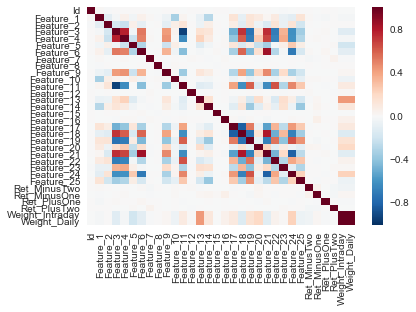

In [235]:
# Looking for correlation
df_corr = df.corr()
sns.heatmap(df_corr, 
            xticklabels=df_corr.columns.values,
            yticklabels=df_corr.columns.values)

There doesn't seem to be any correlation of the features with the return values for both days. Now we look into whether there is a correlation for the returns

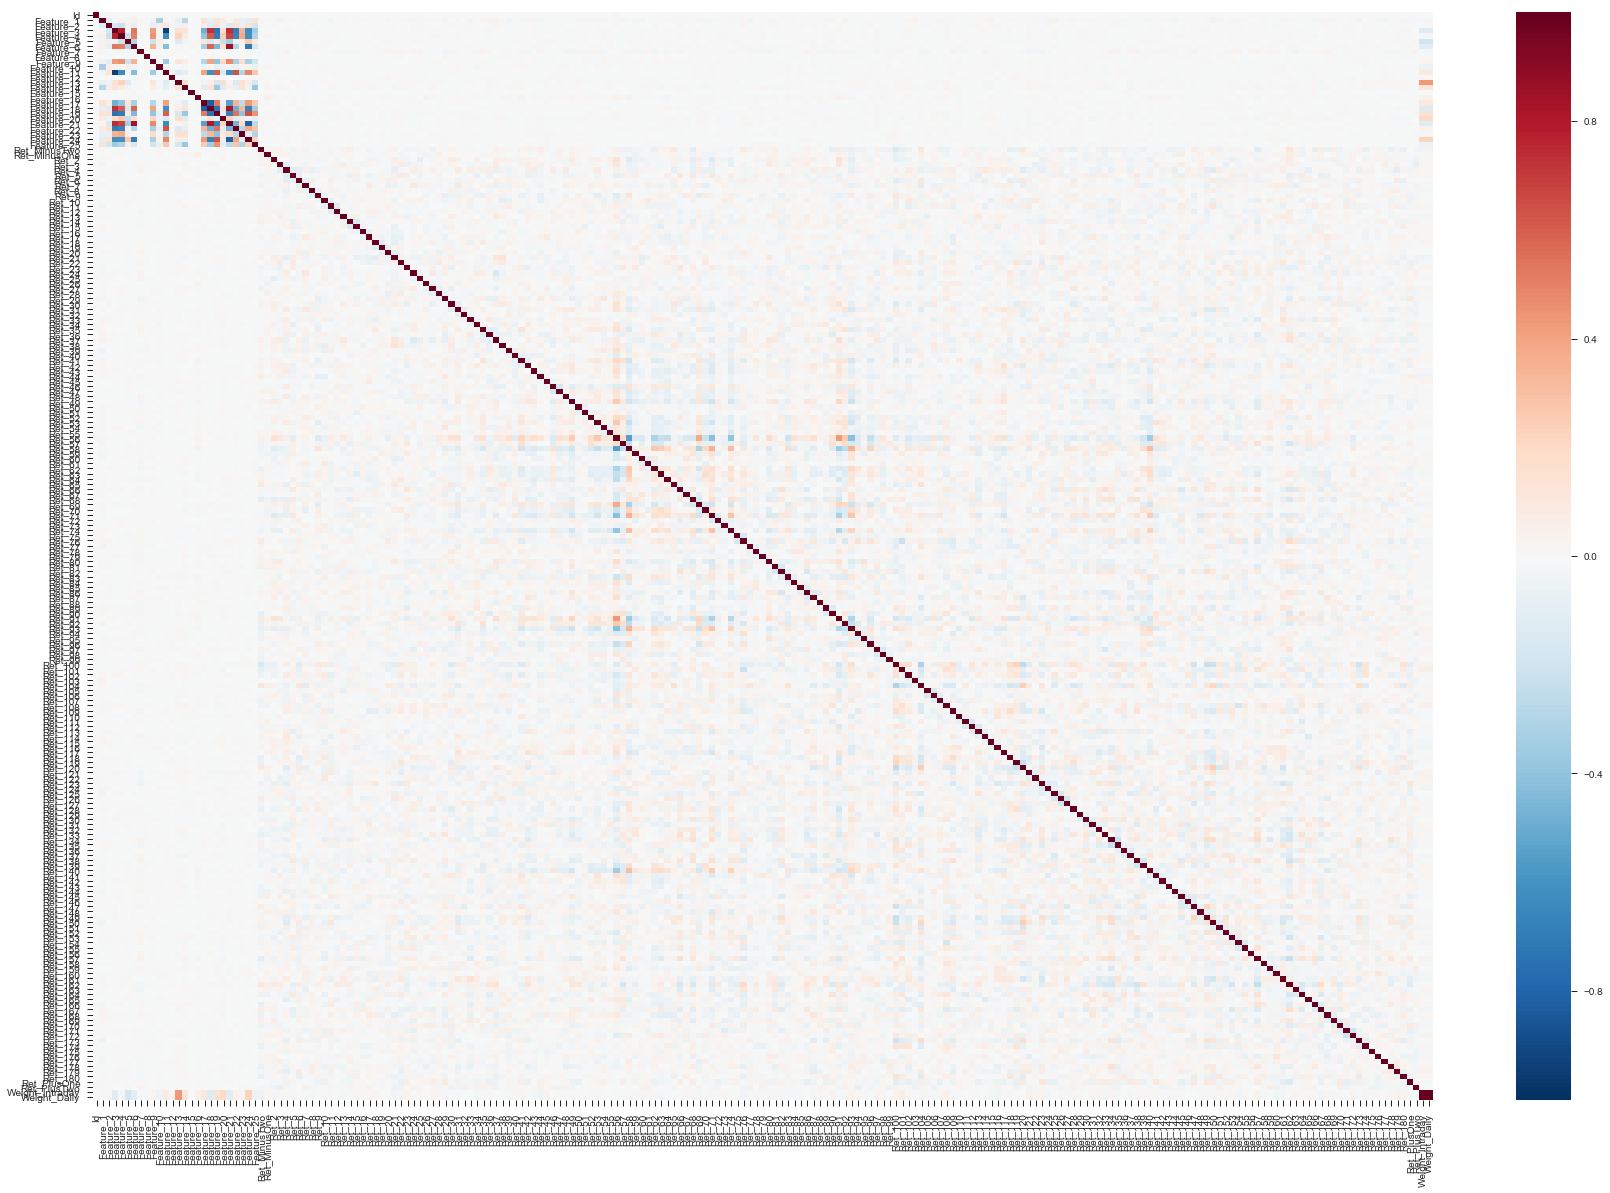

In [236]:
train_corr = train.corr()
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(30, 20)
sns.heatmap(train_corr, 
            xticklabels=train_corr.columns.values,
            yticklabels=train_corr.columns.values, 
           ax=ax)

fig = sns_plot.get_figure()
fig.savefig("C:\\Hafidz\\Playground\\winton\\output.png")

There seem to be little correlation between past and future intraday returns. Let's look a little deeper. Let's start with the means. 

In [237]:
returns = train.loc[:,'Ret_2':'Ret_180']

In [240]:
returns.describe()

,Ret_2,Ret_3,Ret_4,Ret_5,Ret_6,Ret_7,Ret_8,Ret_9,Ret_10,Ret_11,Ret_12,Ret_13,Ret_14,Ret_15,Ret_16,Ret_17,Ret_18,Ret_19,Ret_20,Ret_21,Ret_22,Ret_23,Ret_24,Ret_25,Ret_26,Ret_27,Ret_28,Ret_29,Ret_30,Ret_31,Ret_32,Ret_33,Ret_34,Ret_35,Ret_36,Ret_37,Ret_38,Ret_39,Ret_40,Ret_41,Ret_42,Ret_43,Ret_44,Ret_45,Ret_46,Ret_47,Ret_48,Ret_49,Ret_50,Ret_51,Ret_52,Ret_53,Ret_54,Ret_55,Ret_56,Ret_57,Ret_58,Ret_59,Ret_60,Ret_61,Ret_62,Ret_63,Ret_64,Ret_65,Ret_66,Ret_67,Ret_68,Ret_69,Ret_70,Ret_71,Ret_72,Ret_73,Ret_74,Ret_75,Ret_76,Ret_77,Ret_78,Ret_79,Ret_80,Ret_81,Ret_82,Ret_83,Ret_84,Ret_85,Ret_86,Ret_87,Ret_88,Ret_89,Ret_90,Ret_91,Ret_92,Ret_93,Ret_94,Ret_95,Ret_96,Ret_97,Ret_98,Ret_99,Ret_100,Ret_101,Ret_102,Ret_103,Ret_104,Ret_105,Ret_106,Ret_107,Ret_108,Ret_109,Ret_110,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120,Ret_121,Ret_122,Ret_123,Ret_124,Ret_125,Ret_126,Ret_127,Ret_128,Ret_129,Ret_130,Ret_131,Ret_132,Ret_133,Ret_134,Ret_135,Ret_136,Ret_137,Ret_138,Ret_139,Ret_140,Ret_141,Ret_142,Ret_143,Ret_144,Ret_145,Ret_146,Ret_147,Ret_148,Ret_149,Ret_150,Ret_151,Ret_152,Ret_153,Ret_154,Ret_155,Ret_156,Ret_157,Ret_158,Ret_159,Ret_160,Ret_161,Ret_162,Ret_163,Ret_164,Ret_165,Ret_166,Ret_167,Ret_168,Ret_169,Ret_170,Ret_171,Ret_172,Ret_173,Ret_174,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180
count,3.894600e+04,3.875500e+04,38798.000000,38725.000000,38680.000000,38772.000000,3.879000e+04,3.868300e+04,38687.000000,38631.000000,3.876200e+04,38673.000000,3.863300e+04,38652.000000,3.859800e+04,3.881800e+04,38796.000000,38631.000000,38645.000000,38631.000000,38913.000000,38727.000000,3.866200e+04,3.861600e+04,3.860800e+04,38721.000000,3.865200e+04,38624.000000,3.863600e+04,3.863100e+04,3.898900e+04,3.883200e+04,3.881400e+04,38870.000000,3.879000e+04,3.889200e+04,3.885100e+04,38823.000000,3.882700e+04,38801.000000,38996.000000,3.880800e+04,38864.000000,3.875500e+04,38719.000000,3.900000e+04,38795.000000,3.888300e+04,3.882900e+04,38803.000000,38926.000000,38880.000000,3.894500e+04,3.887500e+04,38892.000000,38966.000000,38959.000000,3.897100e+04,38895.000000,3.895400e+04,39391.000000,3.918200e+04,3.919900e+04,3.915700e+04,3.910400e+04,39239.000000,3.915800e+04,3.916200e+04,3.911300e+04,39135.000000,39306.000000,39184.000000,39166.000000,3.919300e+04,39122.000000,3.929800e+04,39254.000000,39245.000000,3.924200e+04,39223.000000,3.932500e+04,3.922900e+04,3.926300e+04,3.922800e+04,3.922100e+04,3.934300e+04,3.927200e+04,3.925700e+04,3.921500e+04,39253.000000,39560.000000,39397.000000,39405.000000,3.935300e+04,39344.000000,39455.000000,39398.000000,3.940100e+04,3.929100e+04,39336.000000,3.950100e+04,39315.000000,3.936500e+04,3.937500e+04,3.935600e+04,39467.000000,39443.000000,3.937100e+04,3.931900e+04,39360.000000,3.953800e+04,3.945300e+04,39460.000000,39391.000000,3.939900e+04,3.952800e+04,39488.000000,3.949100e+04,4.000000e+04,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,40000.000000,40000.000000,40000.000000,4.000000e+04,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,40000.000000,4.000000e+04,4.000000e+04,40000.000000,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,4.000000e+04,40000.000000,40000.000000
mean,5.600930e-06,-7.659483e-06,-0.000006,-0.000006,-0.000019,0.000030,2.752578e-05,4.696042e-07,0.000004,-0.000004,4.886832e-07,0.000010,2.886394e-05,-0.000005,-1.894765e-05,-2.332589e-05,-0.000015,0.000004,-0.000022,0.000025,0.000009,-0.000042,-1.636305e-05,-2.085704e-05,5.887298e-06,-0.000033,-1.767348e-05,0.000008,-3.223901e-06,1.9982

The above are some basic statistics for the return data. Some observations:
1. Some returns, especially during early, are null. Data "fullness" gets better as the day ends.
2. The returns fluctuates in burst for most counters. It's like everyone trades at the same time contributing to a lot of volatility at the same time, and other minutes - radio silence.

Let's explore item 2 later. 

For now, let's have a look at the distribution of the return at the end of the intraday.

* Notes *
+------------+---------+--------+
|            |  A      |  B     |
+------------+---------+---------
|      0     | 0.626386| 1.52325|----axis=1----->
+------------+---------+--------+
                |         |
                | axis=0  |
                ↓         ↓

#### Check for the typical return

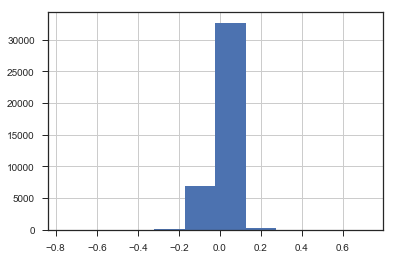

In [331]:
today_tot_ret = returns.sum(axis=1) #axis=1, sums along the x axis (row). if axis=0, it sums along the y-axis(column)
today_tot_ret.hist()

Most of the return are close to zero, on the positive side. We could probably default to this as a first choice.

#### Check for volatility

Doing some exploration on volatility by plotting out some graphs based on some sample daily returns

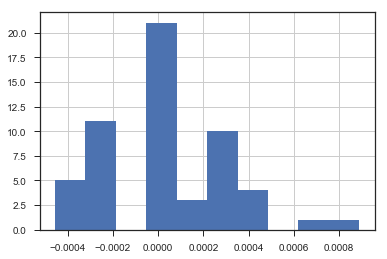

In [290]:
# using row 200, we look at the distribution over 3 time periods.
returns.loc[200][0:60].hist() 

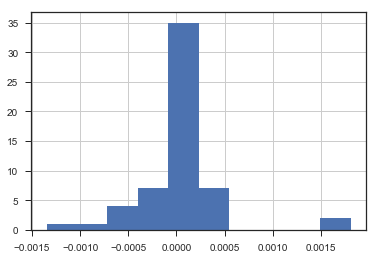

In [289]:
returns.loc[200][61:120].hist() 

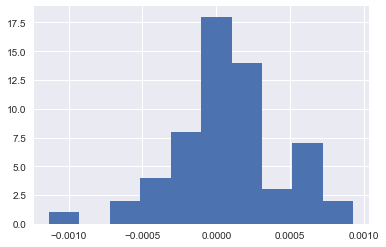

In [340]:
returns.loc[200][120:179].hist()

Based on the above diagrams, we can observe to things:
1.	In the first half of the period, while zero returns are the most frequent; we also see that there are some stocks that are trading positively and some that are trading negatively. Since the time period indicates that it’s the “first-half” of the day, then one can hypothesize that there are a lot of trading activities that occur once the market opens after buyers and sellers have gone through yesterday’s news and speculations.
2.	For the second half of the day, we see that zero returns (or values close to zero since the histograms are in bins) are the most frequent range of returns throughout the period. 
3.	The final half of the day, we see some upswing towards the positive side of returns. However the bulk of returns are still unchanged.

Let's plot the series.

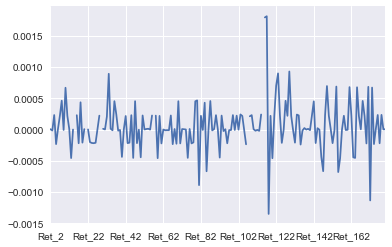

In [339]:
returns.loc[200][0:179].plot()

Quite volatile. Now that we've seen a sample, let's plot the mean for the whole training data.

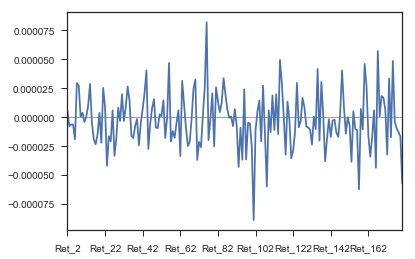

In [333]:
returns.mean(axis=0).plot().axhline(y=0.000,xmin=0,xmax=3,c="red",linewidth=0.5,zorder=0)

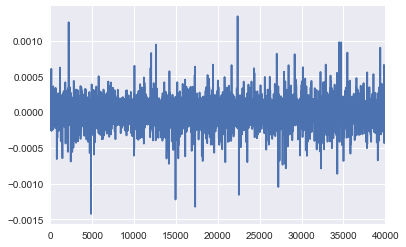

In [377]:
returns.mean(axis=1).plot()

As a whole, the mean looks quite volatile on a daily basis. Let's look at it from a standard deviation's perspective.

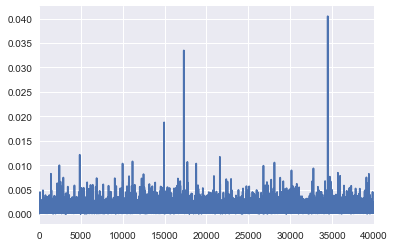

In [374]:
returns.std(axis=1).plot()

On a row basis (stocks return for 5 days), the standard deviation for most of the stocks are relatively low and about the same - minus a few outlier.

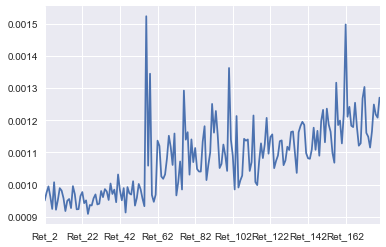

In [375]:
returns.std(axis=0).plot()

However on comparing on minutes perspective, the returns std deviation seems to increase over time. This means that over time, returns get more volatile. In other words, if one wants to sell or buy a share - it is preferable to do so in early morning instead of waiting until mid-day, as it is less predictable.

The second observation is the volatility spike that occurs around Ret_50, and how prior to that, there is very little change in deviation.

Since this information seems interesting, it might be worthwhile to include this as a new feature in our dataset during modelling.



#### Effects of month and date_id on return and volatility

Finally, we want to look at the effects of time has on the stocks - since we already know from the forum that we have month (Feature_5) and date_id (Feature_7). 

Let's first confirm that we have a good number of days for each month.

In [391]:
train.groupby('Feature_5').size().reset_index(name='count')

,Feature_5,count
0,1.0,6340
1,2.0,4557
2,3.0,1756
3,4.0,666
4,5.0,4485
5,6.0,2761
6,7.0,6614
7,8.0,6943
8,9.0,3688
9,10.0,2190


Looks like we have an adequate sample (although we seem to be losing a lot of data in April).

Now let's take an average return across the 4 days per date_id, and take an average of those return by the month - and construct a plot.

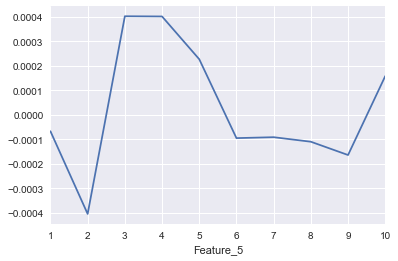

In [414]:
((train['Ret_MinusOne'] + train['Ret_MinusTwo'] + train['Ret_PlusOne'] + train['Ret_PlusTwo'])/4).groupby(train['Feature_5']).mean().plot()

We see that on average most stocks give positive returns on month_id 3 and 4, and later slumps on month_id 5 onwards.

What if median?

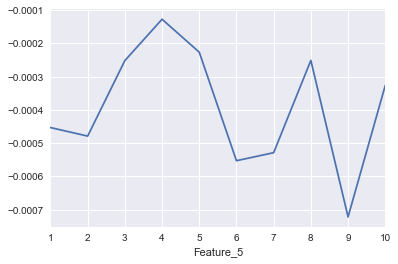

In [443]:
((train['Ret_MinusOne'] + train['Ret_MinusTwo'] + train['Ret_PlusOne'] + train['Ret_PlusTwo'])/4).groupby(train['Feature_5']).median().plot()

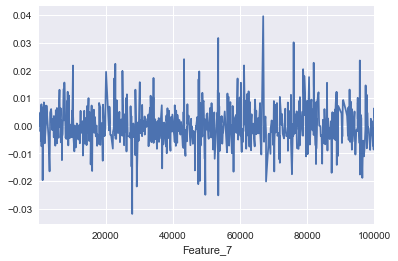

In [409]:
((train['Ret_MinusOne'] + train['Ret_MinusTwo'] + train['Ret_PlusOne'] + train['Ret_PlusTwo'])/4).groupby(train['Feature_7']).mean().plot()

The above is mean (of 4 day average) return for all the stocks on daily basis. Not a lot of pattern there. What if we turn into weekday weekend?

*do some data massaging in excel

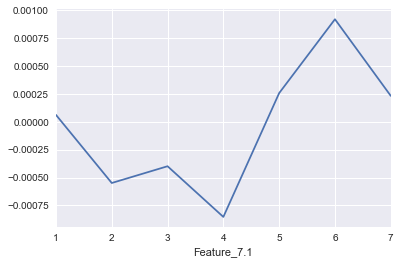

In [417]:
((train['Ret_MinusOne'] + train['Ret_MinusTwo'] + train['Ret_PlusOne'] + train['Ret_PlusTwo'])/4).groupby(train['Feature_7.1']).mean().plot()

What if median?

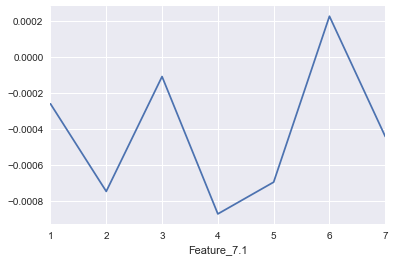

In [440]:
((train['Ret_MinusOne'] + train['Ret_MinusTwo'] + train['Ret_PlusOne'] + train['Ret_PlusTwo'])/4).groupby(train['Feature_7.1']).median().plot()

In [438]:
train.groupby('Feature_7.1').size().reset_index(name='count')

,Feature_7.1,count
0,1,5381
1,2,5930
2,3,5214
3,4,6191
4,5,5919
5,6,5732
6,7,5633


#### Correlation between features and outcome

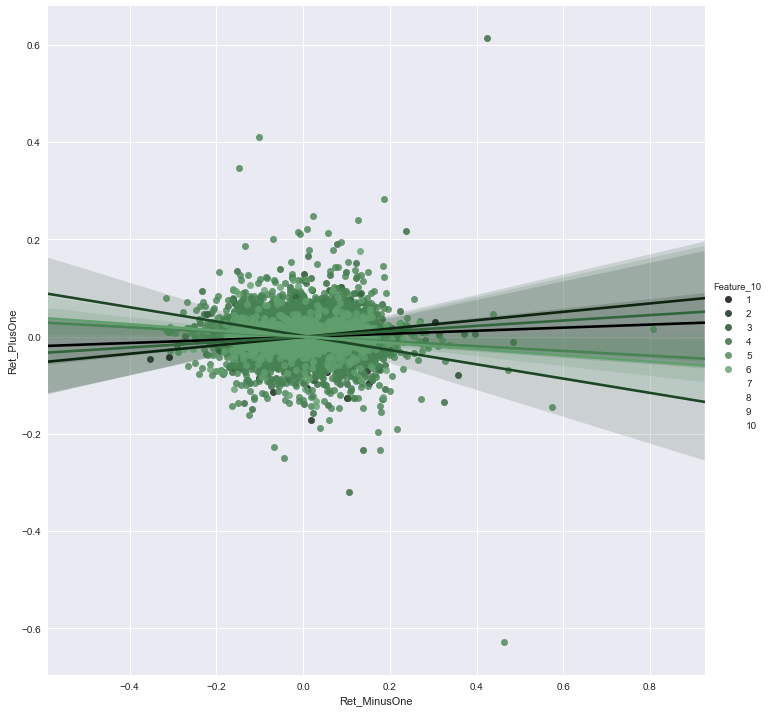

In [163]:
# Based on the above, we can try and see the visualize the correlation between certain features and the outcome that we're interested in
sns.lmplot(data=df, x='Ret_MinusOne', y='Ret_PlusOne', hue='Feature_10', palette=sns.cubehelix_palette(10, start=2, rot=0, dark=0, light=.95, reverse=True), x_jitter=.15, size=10, hue_order=range(1,11,1))

## Data Preparation

Now that we've done some analysis, let's do a proper preparation of our data. We'll do a reset on all variable and reload the whole thing again so that the we're not missing anything

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# load libraries
from __future__ import print_function
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import random
import os
import time
import warnings
from numpy import newaxis
import tensorflow as tf  # Version 1.0 or 0.12
import matplotlib.pyplot as plt

# This is for the notebook to generate inline matplotlib 
# charts rather than to open a new window every time: 
%matplotlib inline

In [3]:
train_data = pd.read_csv("C:\\Hafidz\\Playground\\winton\\train.csv")
test_data = pd.read_csv("C:\\Hafidz\\Playground\\winton\\test_2.csv")
print(train_data.shape)
print(test_data.shape)

(40000, 211)
(120000, 147)


Next we need to :
1. create the new features as per our analysis (for both train and test data)
2. scale (for both train and test data)
3. impute missing values (for both train and test data)
4. prepare train and test (using our train data)
5. prepare data for use with tensorflow lstm 


In [4]:
# libraries
def get_week_id(date_id):
    week_id = date_id % 7 
    return week_id

def fetch_batch_size_random(X, Y, batch_size):
    """
    Returns randomly an aligned batch_size of X and Y among all examples. 
    The external dimension of X and Y must be the batch size (eg: 1 column = 1 example).
    X and Y can be N-dimensional.
    """
    #assert X.shape == Y.shape, (X.shape, Y.shape)
    idxes = np.random.randint(X.shape[0], size=batch_size)
    X_out = np.array(X[idxes]).transpose((1, 0, 2))
    Y_out = np.array(Y[idxes]).transpose((1, 0, 2))
    return X_out, Y_out

X_train = []
Y_train = []
X_test = []
Y_test = []

#### Create new feature 

In [5]:
#create new features
#intra mean
train_data['intra_mean'] = train_data.ix[:,'Ret_2':'Ret_120'].mean(axis=1)
test_data['intra_mean'] = test_data.ix[:,'Ret_2':'Ret_120'].mean(axis=1)

#intra standard deviation
train_data['intra_std'] = train_data.ix[:,'Ret_2':'Ret_120'].std(axis=1)
test_data['intra_std'] = test_data.ix[:,'Ret_2':'Ret_120'].std(axis=1)

#intra median 
train_data['intra_med'] = train_data.ix[:,'Ret_2':'Ret_120'].median(axis=1)
test_data['intra_med'] = test_data.ix[:,'Ret_2':'Ret_120'].median(axis=1)

# day of week
train_data['week_id'] = get_week_id(train_data['Feature_7'])
test_data['week_id'] = get_week_id(test_data['Feature_7'])

#### Scaling
We're not entirely sure whether scaling and data imputation would have an effect on the outcome. Hence, we will skip this.

In [15]:
###scaling the data
"""
from sklearn.preprocessing import StandardScaler

scaling_data = df.drop('Train_Or_Test', axis=1)
scaling_data = np.array(scaling_data.values).astype(np.float32)
scaler = StandardScaler()
scaler.fit(scaling_data)

train_data = train_data.drop('Train_Or_Test', axis=1).values
train_data = np.array(train_data).astype(np.float32)
train_data = scaler.transform(train_data)
test_data = test_data.drop('Train_Or_Test', axis=1).values
test_data = np.array(test_data).astype(np.float32)
test_data = scaler.transform(test_data)
"""


"\nfrom sklearn.preprocessing import StandardScaler\n\nscaling_data = df.drop('Train_Or_Test', axis=1)\nscaling_data = np.array(scaling_data.values).astype(np.float32)\nscaler = StandardScaler()\nscaler.fit(scaling_data)\n\ntrain_data = train_data.drop('Train_Or_Test', axis=1).values\ntrain_data = np.array(train_data).astype(np.float32)\ntrain_data = scaler.transform(train_data)\ntest_data = test_data.drop('Train_Or_Test', axis=1).values\ntest_data = np.array(test_data).astype(np.float32)\ntest_data = scaler.transform(test_data)\n"

#### Scaling

From the blog site machinelearningmastery.com: 

> LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library (http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

Once we've scaled our data, we will need to "denormalize" it back to the original value after applying the prediction.


#### Data Massaging

We'll massage our data so that it conforms to how tensorflow processes data.

In [6]:
#remove unused ones (id, weight_intraday, weight_daily)
train_data = train_data.drop(['Id','Weight_Intraday','Weight_Daily'],1)
test_data = test_data.drop('Id',1)

#rearrange column for train
cols = train_data.columns.tolist()
cols = cols[-4:] + cols[:-4]
#print(cols)

train_data = train_data[cols]
#print (train_data.columns.tolist())

#rearrange column for test
cols = test_data.columns.tolist()
cols = cols[-4:] + cols[:-4]
#print(cols)

test_data = test_data[cols]
#print(test_data.columns.tolist())

#### Imputing

To simplify this, we'll be imputing the missing data for intraday period with 0.

In [7]:
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

In [8]:
# create back up of processed data before doing separation and modelling

train_data_processed = train_data
test_data_processed = test_data

#### Configure parameters

In [12]:
# Internal neural network parameters

"""
if pad_output = 1, these will be ammended:
    1. df_train and df_test will be padded with zeroes such that length of input sequence will be the same as output_sequence
    2. seq_length will not assume same length of input encoder and output decoder tensor. New value will be used to represent 
    length of input and output tensor
"""


# submission: 1
pad_output = 1
batch_size = 5  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!
output_dim = input_dim = 1  # Output dimension (e.g.: multiple signals at once, tied in time)
hidden_dim = 160  # Count of hidden neurons in the recurrent units. 
layers_stacked_count = 2  # Number of stacked recurrent cells, on the neural depth axis. 

# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
nb_iters = 1000  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting


'''
# submission: 2
  changes: changed some parameter value from submission 1. Also introduced customized dec_inp tensor that uses the same 
  length as expected output



pad_output = 1
batch_size = 50  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!
input_vocab_size = 1000
output_vocab_size = 1000

seq_length = 150
output_dim = input_dim = 1  # Output dimension (e.g.: multiple signals at once, tied in time)
hidden_dim = 50  # Count of hidden neurons in the recurrent units. 
layers_stacked_count = 2  # Number of stacked recurrent cells, on the neural depth axis. 

# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
nb_iters = 1000  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting
'''

'\n# submission: 2\n  changes: changed some parameter value from submission 1. Also introduced customized dec_inp tensor that uses the same \n  length as expected output\n\n\n\npad_output = 1\nbatch_size = 50  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!\ninput_vocab_size = 1000\noutput_vocab_size = 1000\n\nseq_length = 150\noutput_dim = input_dim = 1  # Output dimension (e.g.: multiple signals at once, tied in time)\nhidden_dim = 50  # Count of hidden neurons in the recurrent units. \nlayers_stacked_count = 2  # Number of stacked recurrent cells, on the neural depth axis. \n\n# Optmizer: \nlearning_rate = 0.007  # Small lr helps not to diverge during training. \nnb_iters = 1000  # How many times we perform a training step (therefore how many times we show a batch). \nlr_decay = 0.92  # default: 0.9 . Simulated annealing.\nmomentum = 0.5  # default: 0.0 . Momentum technique in weights update\nlambda_l2_reg = 0.003  # L2 regularization of 

#### Train/Test separation

In [13]:
#split training_data into train and test
np.random.seed(4815)

df=train_data
df['Train_Or_Test'] = np.random.rand(len(df.index), 1) >= 0.7
df = df.fillna(-1)

#checking the count for train and test
print(df.groupby('Train_Or_Test').size().reset_index(name='count'))

df_train = df[df['Train_Or_Test'] == False]
df_test = df[df['Train_Or_Test'] == True]

#drop the train_or_test column
df_train = df_train.drop(['Train_Or_Test'],1)
df_test = df_test.drop(['Train_Or_Test'],1)

  Train_Or_Test  count
0         False  27945
1          True  12055


#### Prepare data for modelling

In [14]:
#split train and test into left (train sequence) and right (outcome sequence) 

#we want to train column 1 - 150, and we want to predict column (sequence) 151 to the end.

#convert panda dataframe to numpy arrays
df_train = df_train.values
df_test = df_test.values

if pad_output == 1:
    df_train = np.concatenate((df_train, np.zeros((27945,88))), axis=1)
    df_test = np.concatenate((df_test, np.zeros((12055,88))), axis=1) 

X_train = np.expand_dims(df_train[:,0:150], axis=2)
Y_train = np.expand_dims(df_train[:,150:], axis=2)
X_test = np.expand_dims(df_test[:,0:150], axis=2)
Y_test = np.expand_dims(df_test[:,150:], axis=2)

print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

seq_length = X_train.shape[1]  # Time series will have the same past and future (to be predicted) lenght. 

X_train: (27945, 150, 1)
Y_train: (27945, 150, 1)
X_test: (12055, 150, 1)
Y_test: (12055, 150, 1)


In [18]:
#load tensorflow library
import tensorflow as tf


# Backward compatibility for TensorFlow's version 0.12: 
try:
    tf.nn.seq2seq = tf.contrib.legacy_seq2seq
    tf.nn.rnn_cell = tf.contrib.rnn
    tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
    print ("TensorFlow's version : 1.0 (or more)")
except: 
    print ("TensorFlow's version : 0.12")

TensorFlow's version : 1.0 (or more)


In [26]:
tf.reset_default_graph()
try:
    sess.close()
except: 
    pass

sess = tf.InteractiveSession()

In [27]:

with tf.variable_scope('Seq2seq'):

    # Encoder: inputs
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
           for t in range(seq_length)
    ]

    # Decoder: expected outputs
    label = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="label".format(t))
          for t in range(seq_length)
    ]
    
    # Give a "GO" token to the decoder. 
    # You might want to revise what is the appended value "+ enc_inp[:-1]". 
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO") ] + enc_inp[:-1]

    # Create a `layers_stacked_count` of stacked RNNs (GRU cells here). 
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            # cells.append(tf.nn.rnn_cell.BasicLSTMCell(...))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    # For reshaping the input and output dimensions of the seq2seq RNN: 
    w_in = tf.Variable(tf.random_normal([input_dim, hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim], mean=1.0))
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    reshaped_inputs = [tf.nn.relu(tf.matmul(i, w_in) + b_in) for i in enc_inp]
    
    # Here, the encoder and the decoder uses the same cell, HOWEVER,
    # the weights aren't shared among the encoder and decoder, we have two
    # sets of weights created under the hood according to that function's def. 
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp, 
        dec_inp, 
        cell
    )
    
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    # Final outputs: with linear rescaling similar to batch norm, 
    # but without the "norm" part of batch normalization hehe. 
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]
   

In [29]:

# Training loss and optimizer

with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, label):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        
    # L2 regularization (to avoid overfitting and to have a  better generalization capacity)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
            
    loss = output_loss + lambda_l2_reg * reg_loss

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)

In [31]:

def train_batch_hfz(batch_size):
    """
    Training step that optimizes the weights 
    provided some batch_size X and Y examples from the dataset. 
    """
    
    X, Y = fetch_batch_size_random(X_train, Y_train, batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({label[t]: Y[t] for t in range(len(label))})
    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t

def test_batch_hfz(batch_size):
    """
    Test step, does NOT optimizes. Weights are frozen by not <
    doing sess.run on the train_op. 
    """

    X, Y = fetch_batch_size_random(X_test, Y_test, batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({label[t]: Y[t] for t in range(len(label))})
    loss_t = sess.run([loss], feed_dict)
    return loss_t[0]


# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer()) #to understand this line, check this out http://learningtensorflow.com/lesson2/

for t in range(nb_iters+1):
    train_loss = train_batch_hfz(batch_size)
    train_losses.append(train_loss)
    
    if t % 10 == 0: 
        # Tester
        test_loss = test_batch_hfz(batch_size)
        test_losses.append(test_loss)
        print ("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters, train_loss, test_loss))

print ("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))

Step 0/1000, train loss: 1298.607666015625, 	TEST loss: 147254.65625
Step 10/1000, train loss: 93584.0859375, 	TEST loss: 46395.68359375
Step 20/1000, train loss: 924.6236572265625, 	TEST loss: 1318.8580322265625
Step 30/1000, train loss: 239.5880126953125, 	TEST loss: 200.78152465820312
Step 40/1000, train loss: 67.49624633789062, 	TEST loss: 67.4901351928711
Step 50/1000, train loss: 87.23204803466797, 	TEST loss: 31.80264663696289
Step 60/1000, train loss: 13.777229309082031, 	TEST loss: 13.031471252441406
Step 70/1000, train loss: 11.285170555114746, 	TEST loss: 11.269834518432617
Step 80/1000, train loss: 159.98016357421875, 	TEST loss: 540.2896118164062
Step 90/1000, train loss: 11.919438362121582, 	TEST loss: 11.306562423706055
Step 100/1000, train loss: 10.658365249633789, 	TEST loss: 10.693185806274414
Step 110/1000, train loss: 212.53042602539062, 	TEST loss: 582.3040161132812
Step 120/1000, train loss: 10.51333236694336, 	TEST loss: 10.501964569091797
Step 130/1000, train lo

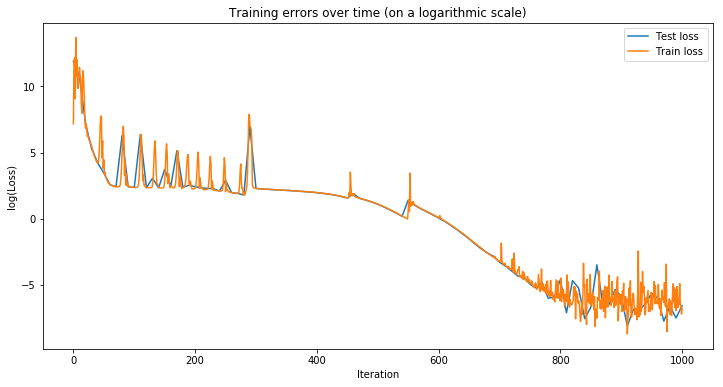

In [32]:
#Graph of errors over time :
plt.figure(figsize=(12, 6))
plt.plot(
    np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), 
    np.log(test_losses), 
    label="Test loss"
)
plt.plot(
    np.log(train_losses), 
    label="Train loss"
)
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()


Let's visualize 5 predictions with our signals:


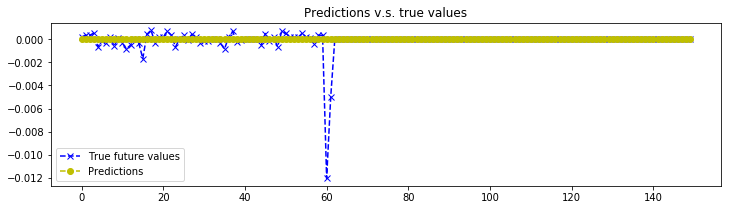

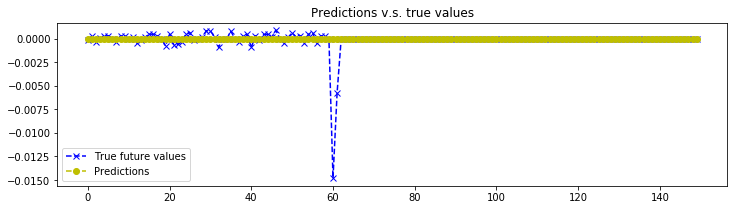

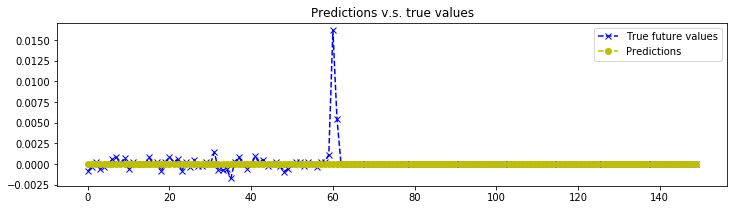

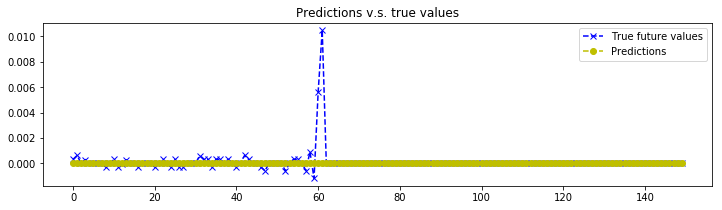

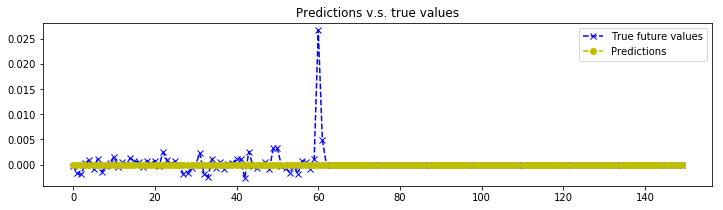

expected: 150
predicted: 150
Reminder: the last two points (61 and 62) corresponds to T+1 and T+2 returns instead of intraday returns.
Reminder: onwards from point 62 are just padding of zeroes.


In [34]:
# Tester
nb_predictions = 5
print ("Let's visualize {} predictions with our signals:".format(nb_predictions))

#X, Y = generate_x_y_data(isTrain=False, batch_size=nb_predictions)
X, Y = fetch_batch_size_random(X_test, Y_test, batch_size)
#if pad_output == 1:
feed_dict = {enc_inp[t]: X[t] for t in range(seq_length)}
#else:
#    feed_dict = {enc_inp[t]: X[t] for t in range(seq_length_enc)}
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])

for j in range(nb_predictions): 
    plt.figure(figsize=(12, 3))
    
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs[:,j,k]
        
        #label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        #plt.plot(range(len(past)), past, "o--b", label=label1)
        #plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label=label2)
        #plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)
        plt.plot(range(len(expected)), expected, "x--b", label=label2)
        plt.plot(range(len(pred)), pred, "o--y", label=label3)
        
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

#print ("past:",len(past))
print ("expected:",len(expected))
print ("predicted:",len(pred))
print ("Reminder: the last two points (61 and 62) corresponds to T+1 and T+2 returns instead of intraday returns.")
print ("Reminder: onwards from point 62 are just padding of zeroes.")

#### Produce output for Kaggle scoring

In [35]:
#df_eval = test_data.values
df_eval = np.expand_dims(test_data.values, axis=2)
df_eval = np.array(df_eval).transpose((1, 0, 2))
feed_dict = {enc_inp[t]: df_eval[t] for t in range(len(df_eval))}
output = np.array(sess.run([reshaped_outputs], feed_dict)[0])
output = np.array(output).transpose(1,0,2)
print("output shape:",outputs.shape)

# if decoded output was embedded, we will need to remove the padding
output2 = output[:,0:62]
print("output2 shape:",output2.shape)


output shape: (150, 5, 1)
output2 shape: (120000, 62, 1)


In [36]:
# Expected output file format
# Id, Predicted
# 1_1, 0
# 1_2, 0
# 1_3, 0

pred_output = []
output2 = np.nan_to_num(output2) # replace NaN with zeroes if any
for j in range(output2.shape[0]):
    for i in range(output2.shape[1]):
        col_id = "%s_%s" % (j+1,i+1)
        pred_val = output2[j,i,0]
        pred_output.append(np.array([col_id,pred_val]))

pred_output = np.array(pred_output)
print(pred_output.shape)

(7440000, 2)


In [37]:
#change format to pandas dataframe, and assign column name
pred_output = pd.DataFrame(pred_output, columns=['Id','Predicted'])
pred_output.head(5)

,Id,Predicted
0,1_1,-8.20864e-06
1,1_2,-8.20864e-06
2,1_3,-8.20864e-06
3,1_4,-8.20864e-06
4,1_5,-8.20864e-06


In [38]:
out_file_path = 'C:\\Hafidz\\Playground\\Udacity\\Machine Learning Nanodegree\\Capstone - Predict Stock Market\\approach_2\\predicted2.csv'
pred_output.to_csv(out_file_path, index=False) 

## Reflections

1. The model tends to generate a single value as the prediction.
2. This could be due to the padding being used.
3. Moving forward, one way to circumvent point #2 is to use variable length sequence or bucketing.
4. Another alternative is to use dynamic RNN function available in Tensorflow.